In [1]:
import pandas as pd
import requests
import json
import dml
import prov.model
import datetime
import uuid
import csv 
from io import StringIO
import json
import pymongo
import numpy as np

import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [2]:
contributor = 'mmao95_Dongyihe_weijiang_zhukk'
reads = [contributor + '.streetbook_filtered']
writes = [contributor + '.street_clustered_location']

In [3]:
startTime = datetime.datetime.now()

# Set up the database connection.
client = dml.pymongo.MongoClient()
repo = client.repo
repo.authenticate(contributor, contributor)

True

In [4]:
streetbook_filtered_list = list(repo[reads[0]].find())
streetbook_filtered_df = pd.DataFrame(streetbook_filtered_list)
streetbook_filtered_list = np.array(streetbook_filtered_df).tolist()

street_lat_long = pd.read_csv("http://datamechanics.io/data/roads_2013_jzi.csv").values.tolist()

In [5]:
print(streetbook_filtered_list[0])
print(street_lat_long[0])

['Abbotsford Street,', 'Abbotsford', '02121', ObjectId('5cbb8e361877df585c0f8949')]
['roads_2013_jzi.1', 'MULTILINESTRING ((-71.158407 42.260028, -71.158463 42.260158))', 25, 25, 85728971, 205866436, 205862089, 'S1400', 'Stimson St', 2758.0, nan, nan, nan, nan, nan, nan, 15.16, 5, 5, 0, 0, 'None', 250251304043.0, 25025130404.0]


In [6]:
# process street latitude and longitude dataset
street_lat_long_data = [(fullName, location, length) for (fId, location, s, c, tl, tf, tf2, m, fullName,
                                                    sm, lf, lt, rf, rt, zi, zipr, length, classGroup, r,
                                                    cluster, m, zone, bg, ct) in street_lat_long]

# print(street_lat_long[0])
lat_long_df = pd.DataFrame(street_lat_long_data)
lat_long_df.columns = ['fullName', 'location', 'length']
lat_long_df = lat_long_df.dropna()

In [7]:
lat_long_list = np.array(lat_long_df).tolist()
print(lat_long_list[0])

['Stimson St', 'MULTILINESTRING ((-71.158407 42.260028, -71.158463 42.260158))', 15.16]


In [8]:
# normalize latitude and longitude list
for i in range(0, len(lat_long_list)):
    lat_long_list[i][1] = lat_long_list[i][1][18 : -2]

for i in range(0, len(lat_long_list)):
    pairs = lat_long_list[i][1].split(',')
    for j in range(0, len(pairs)):
        pairs[j] = pairs[j].lstrip()
    
    pair_tuple = []
    for j in range(0, len(pairs)):
        str = pairs[j].split(' ')
        pair_tuple.append((float(str[0]), float(str[1])))
    lat_long_list[i][1] = pair_tuple

print(len(lat_long_list))

20233


In [9]:
# aggregate same street name
def aggregate(R, f):
    keys = {r[0] for r in R}
    return [(key, f([v for (k,v) in R if k == key])) for key in keys]

In [10]:
# lat_long_list = [(fullName, (location, length)) for (fullName, location, length) in lat_long_list]
name_unique = np.array(lat_long_df['fullName'].unique()).tolist()
street_agg_list = [[fullName, [], 0] for fullName in name_unique]
print(type(street_agg_list[0][1]))
print(type(lat_long_list[0][1]))
for i in range(0, len(street_agg_list)):
    for j in range(0, len(lat_long_list)):
        if(street_agg_list[i][0] == lat_long_list[j][0]):
            street_agg_list[i][1].extend(lat_long_list[j][1])
            street_agg_list[i][2] += lat_long_list[j][2]
            
print(street_agg_list[4])

<class 'list'>
<class 'list'>
['Weymouth Ave', [(-71.151772, 42.266096), (-71.151862, 42.266202), (-71.15186199999998, 42.266201999999986), (-71.15228499999999, 42.266504999999995), (-71.15292599999998, 42.267053999999995), (-71.153097, 42.26720799999999)], 165.29]


In [11]:
# process datasets for K means
output_street_location = []
for i in range(0, len(street_agg_list)):
    count1 = 0
    count2 = 0
    for j in range(0, len(street_agg_list[i][1])):
        count1 += street_agg_list[i][1][j][0]
        count2 += street_agg_list[i][1][j][1]
    output_street_location += [[street_agg_list[i][0], count1 / len(street_agg_list[i][1]), count2 / len(street_agg_list[i][1]), street_agg_list[i][2]]]
print(len(output_street_location))

4567


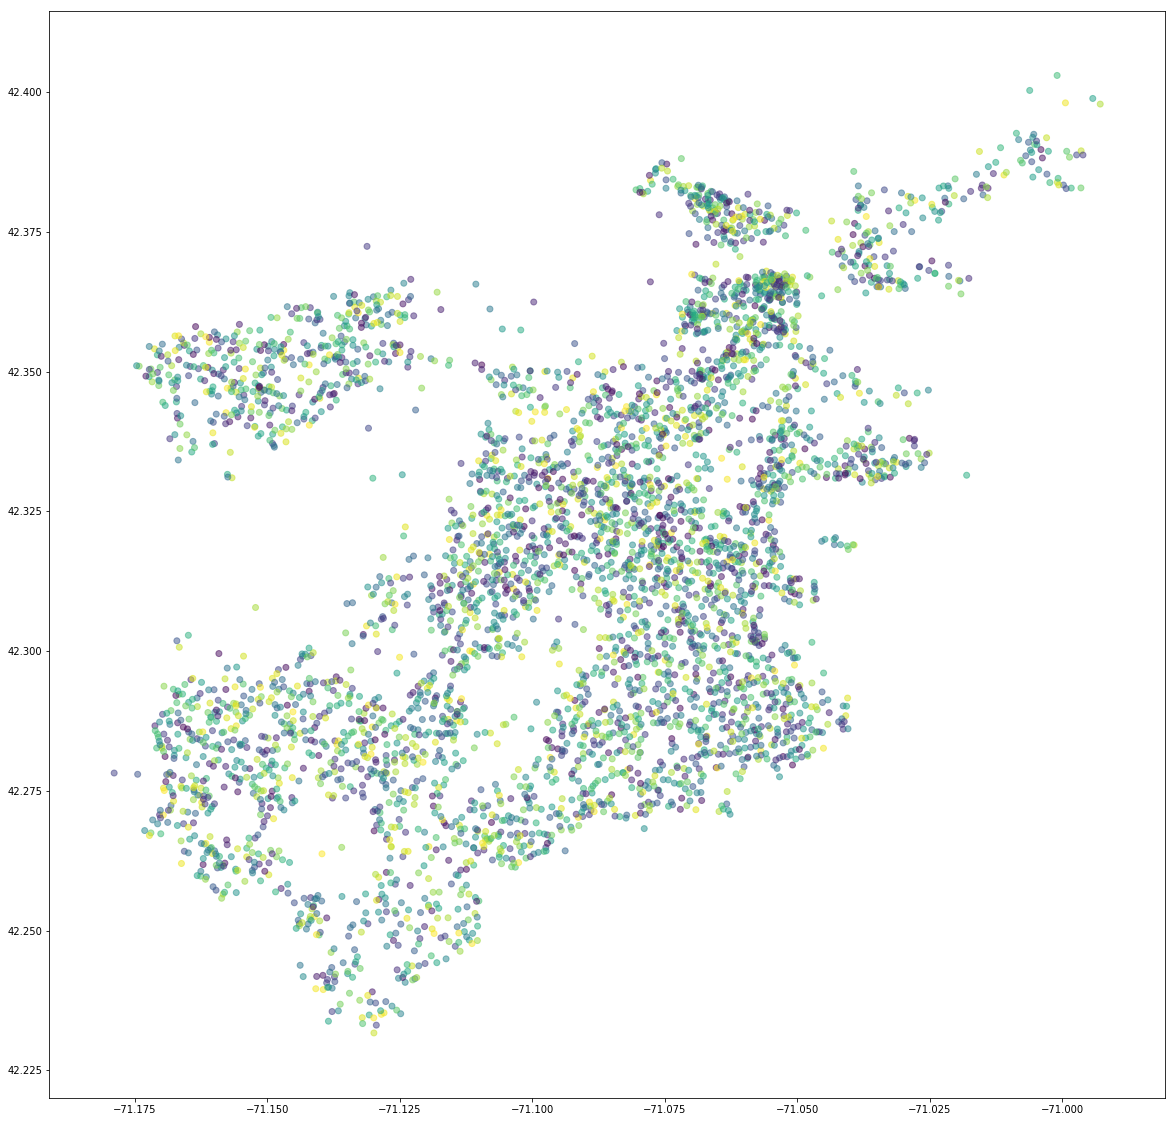

In [12]:
long_lat_list = [(long, lat) for (fullName, long, lat, length) in output_street_location]
long_lat_df = pd.DataFrame(long_lat_list)
long_lat_df.columns = ['long', 'lat']
x = long_lat_df['long']
y = long_lat_df['lat']
colors = np.random.rand(len(long_lat_df))
plt.figure(figsize=(20,20))
plt.scatter(x, y,c = colors, alpha = 0.5)
plt.show()

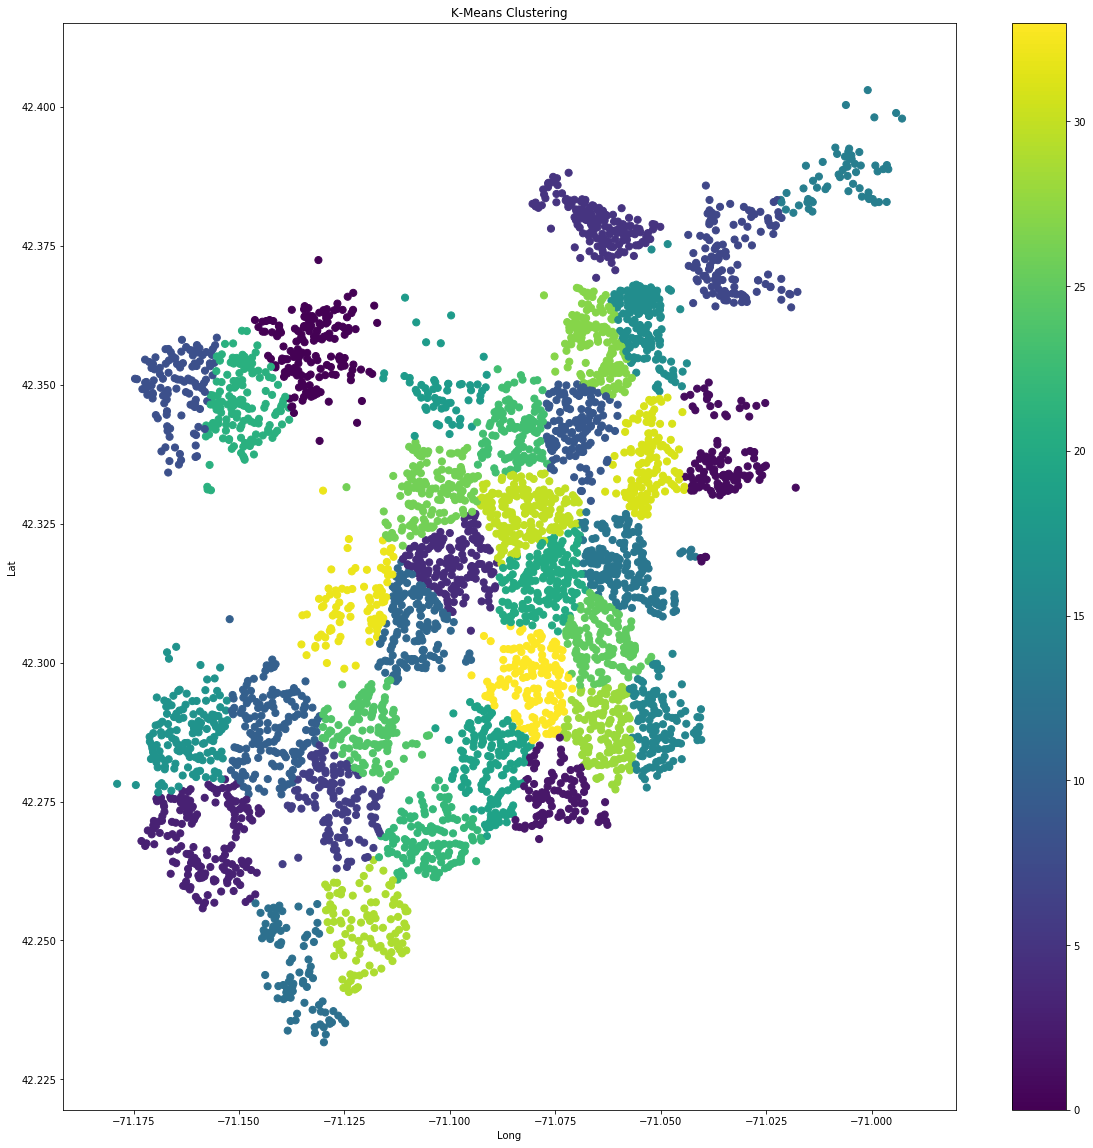

In [13]:
# set datasets into 34 clusters
X = long_lat_df
X = X[~np.isnan(X)]

#K means Clustering 
def doKmeans(X, nclust):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(X, 34)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

#Plot the clusters obtained using k means
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['long'],X['lat'],
                     c = kmeans[0],s = 50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)

In [14]:
kmeans_list = np.array(kmeans).tolist()
for i in range(0, len(output_street_location)):
    output_street_location[i] += (kmeans_list[i])

print(output_street_location)

[['Stimson St', -71.16210674358973, 42.261810846153836, 992.73, 3], ['Grove St', -71.14318346969696, 42.27903903030301, 1704.0800000000002, 10], ['Washington St', -71.10704185440608, 42.309478670498066, 26210.980000000003, 11], ['Rockingham Ave', -71.15560211764705, 42.264634764705875, 312.82, 3], ['Weymouth Ave', -71.15230066666666, 42.266544499999995, 165.29, 3], ['Vershire St', -71.14684733333333, 42.2715701111111, 201.7, 3], ['Cowing St', -71.14794948, 42.2738862, 616.0899999999999, 3], ['Buchanan Rd', -71.13697786206896, 42.29539620689655, 601.33, 10], ['Centre St', -71.12502912400633, 42.298888465818784, 14643.889999999998, 32], ['Starbird Ave', -71.11480442857143, 42.28472528571428, 263.24, 24], ['Neponset Ave', -71.06856199999997, 42.283470074829914, 3973.0900000000006, 28], ['Canterbury St', -71.11038266911767, 42.2851104632353, 3395.15, 24], ['American Legion Hwy', -71.10496155502388, 42.286906392344505, 7878.700000000001, 24], ['Jalleison St', -71.1166894, 42.276050399999995

In [15]:
print(len(output_street_location))
print(output_street_location[4])

4567
['Weymouth Ave', -71.15230066666666, 42.266544499999995, 165.29, 3]


In [16]:
street_clustered = [[cluster, fullName] for (fullName, long, lat, length, cluster) in output_street_location]
result = [[i, ] for i in range(0, 34)]
for i in range(0, 34):
    for j in range(0, len(street_clustered)):
        if(i == street_clustered[j][0]):
            result[i] += [street_clustered[j][1]]

print(result[0])
print(len(result[0]))

[0, 'Commonwealth Ave', 'Hooker St', 'Sorrento St', 'Brighton Ave', 'Gorham St', 'N Arsenal St', 'N Harvard St', 'Western Ave', 'Soldiers Field Rd', 'Brainerd Rd', 'Gaffney St', 'Hichborn St', 'Rotterdam St', 'Bronsdon St', 'Seven Pine Rd', 'Everett Sq', 'Allston St', 'Sinclair Rd', 'Waverly St', 'Gordon St', 'Pomeroy St', 'Saunders St', 'Spurr St', 'Easton St', 'Bertram St', 'Myrick St', 'Mansfield St', 'Highgate St', 'Farrington Ave', 'Armington St', 'Quint Ave', 'Glenville Ave', 'Feneno Ter', 'Parkvale Ave', 'River Street Brg', 'Ashford St', 'Athol St', 'Litchfield St', 'Braintree St', 'Imrie Rd', 'Wadsworth St', 'Windom St', 'Sawyer Ter', 'Kelton St', 'N325', 'Antwerp St', 'Eatonia St', 'Western Pl', 'W Sorrento St', 'Callahan Pl', 'Hefferan St', 'Harvey Steel Rd', 'Herrick St', 'Guilford St', 'Eliot Brg', 'Holton St', 'Craftsman St', 'Weitz St', 'Pratt St', 'Cambridge Ter', 'Long Ave', 'Scottfield Rd', 'Manton Ter', 'Seattle St', 'Raymond St', 'Westford St', 'Hano St', 'Babcock St

In [17]:
# generate csv file
# street_agg_list
street_agg_df = pd.DataFrame(street_agg_list)
street_agg_df.columns = ['Full Name', 'Longitude and Latitude', 'Street Length']
street_agg_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_agg.csv")
# output_street_location
output_street_location_df = pd.DataFrame(output_street_location)
output_street_location_df.columns = ['Full Name', 'Longitude', 'Latitude', 'Street Length', 'Cluster']
output_street_location_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_location.csv")
# result
result_df = pd.DataFrame(result) 
result_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_clustered.csv")

In [18]:
data = json.loads(output_street_location_df.to_json(orient="records"))
repo.dropCollection('street_clustered_location')
repo.createCollection('street_clustered_location')
repo[writes[0]].insert_many(data)

In [19]:
repo[writes[0]].metadata({'complete': True})
print(repo[writes[0]].metadata())
[record for record in repo[writes[0]].find()]

{'_id': ObjectId('5cbbdbf01877df650175920f'), 'complete': True}


[{'_id': ObjectId('5cbbdbf01877df6501758038'),
  'Full Name': 'Stimson St',
  'Longitude': -71.1621067436,
  'Latitude': 42.2618108462,
  'Street Length': 992.73,
  'Cluster': 3},
 {'_id': ObjectId('5cbbdbf01877df6501758039'),
  'Full Name': 'Grove St',
  'Longitude': -71.1431834697,
  'Latitude': 42.2790390303,
  'Street Length': 1704.08,
  'Cluster': 10},
 {'_id': ObjectId('5cbbdbf01877df650175803a'),
  'Full Name': 'Washington St',
  'Longitude': -71.1070418544,
  'Latitude': 42.3094786705,
  'Street Length': 26210.98,
  'Cluster': 11},
 {'_id': ObjectId('5cbbdbf01877df650175803b'),
  'Full Name': 'Rockingham Ave',
  'Longitude': -71.1556021176,
  'Latitude': 42.2646347647,
  'Street Length': 312.82,
  'Cluster': 3},
 {'_id': ObjectId('5cbbdbf01877df650175803c'),
  'Full Name': 'Weymouth Ave',
  'Longitude': -71.1523006667,
  'Latitude': 42.2665445,
  'Street Length': 165.29,
  'Cluster': 3},
 {'_id': ObjectId('5cbbdbf01877df650175803d'),
  'Full Name': 'Vershire St',
  'Longitude':

In [20]:
repo.logout()
endTime = datetime.datetime.now()
{"start":startTime, "end":endTime}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Database.logout() is deprecated
  """Entry point for launching an IPython kernel.


{'start': datetime.datetime(2019, 4, 20, 22, 56, 29, 432631),
 'end': datetime.datetime(2019, 4, 20, 22, 56, 48, 693798)}

In [21]:
# doc = prov.model.ProvDocument()
# startTime = None
# endTime = None
# client = dml.pymongo.MongoClient()
# repo = client.repo
# repo.authenticate(contributor, contributor)

# doc.add_namespace('alg', 'http://datamechanics.io/algorithm/') # The scripts are in <folder>#<filename> format.
# doc.add_namespace('dat', 'http://datamechanics.io/data/') # The data sets are in <user>#<collection> format.
# doc.add_namespace('ont', 'http://datamechanics.io/ontology#') # 'Extension', 'DataResource', 'DataSet', 'Retrieval', 'Query', or 'Computation'.
# doc.add_namespace('log', 'http://datamechanics.io/log/') # The event log.
# doc.add_namespace('bdp', 'https://www.50states.com/bio/mass.htm')

# this_script = doc.agent('alg:'+contributor+'#filtered_famous_people_streets', {prov.model.PROV_TYPE:prov.model.PROV['SoftwareAgent'], 'ont:Extension':'py'})
# res_fp = doc.entity('bdp:fp', {'prov:label':'Famous People in MA', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'json'})
# res_sb = doc.entity('bdp:sb', {'prov:label':'Street Book', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'json'})
# filter_names = doc.activity('log:uuid'+str(uuid.uuid4()), startTime, endTime)
# doc.wasAssociatedWith(filter_names, this_script)
# doc.usage(filter_names, res_fp, startTime, None,
#     {prov.model.PROV_TYPE: 'ont:Computation',
#     'ont:Computation':'Selection, Differentiate'
#     }
# )
# doc.usage(filter_names, res_sb, startTime, None,
#     {prov.model.PROV_TYPE: 'ont:Computation',
#     'ont:Computation':'Selection, Differentiate'
#     }
# )
# result = doc.entity('dat:'+contributor+'#filtered_famous_people_streets', {prov.model.PROV_LABEL:'Streets without Famous People', prov.model.PROV_TYPE:'ont:DataSet'})
# doc.wasAttributedTo(result, this_script)
# doc.wasGeneratedBy(result, filter_names, endTime)
# doc.wasDerivedFrom(result, res_fp, filter_names, filter_names, filter_names)
# doc.wasDerivedFrom(result, res_sb, filter_names, filter_names, filter_names)

# repo.logout()
# doc